
# **0. 준비**

In [ ]:
# 나눔 폰트 설치 / 한글 깨짐 방지 , 런타임 다시 시작하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 33 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fo

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, f1_score

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


---

# **1. 사과 데이터 불러오기**

- 제공받은 apple 데이터

In [ ]:
# 제공받은 후지 사과 데이터 불러오기
df = pd.read_excel("/home/work/.data/data/data.xlsx")

df_fuji = df[df['품종']=='후지']
df_fuji

,조사일,과원이름,품종,시험수,과실번호,과중,종경,횡경,L/D 비,경도1,경도2,당도,산도,착색(L),착색(a),착색(b)
15,2015-11-02,김제,후지,1,1,356.0,85.5,96.4,0.890000,30.913,31.473,16.0,0.439000,47.640,25.710,21.350
16,2015-11-02,김제,후지,1,2,310.0,83.3,91.9,0.910000,26.144,31.174,16.3,NaN,47.130,21.110,19.480
17,2015-11-02,김제,후지,1,3,309.5,82.1,91.8,0.890000,31.902,32.643,10.2,0.397000,51.960,15.070,20.250
18,2015-11-02,김제,후지,1,4,341.0,86.9,92.1,0.940000,32.488,33.291,16.2,NaN,53.830,23.140,26.040
19,2015-11-02,김제,후지,1,5,407.5,88.8,98.9,0.900000,32.260,35.515,15.3,0.289000,52.810,17.130,27.740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2022-10-27,포천,후지,3,6,276.5,77.2,88.0,0.877273,30.598,30.598,13.6,0.308736,39.780,24.100,15.480
1506,2022-10-27,포천,후지,3,7,250.0,69.9,83.3,0.839136,35.500,35.500,14.6,0.390342,42.765,22.910,16.040
1507,2022-10-27,포천,후지,3,8,284.0,80.8,88.1,0.917140,29.327,29.327,13.9,0.323744,42.720,23.235,15.120
1508,2022-10-27,포천,후지,3,9,359.0,84.9,94.0,0.903191,30.975,30.975,14.4,0.354430,39.120,24.690,14.710


---

# **2. 사과 품질 칼럼 만들기**

타겟데이터인 품질 칼럼을 생성하고 이를 예측한다.


등급별 기준은 논문 사실에 기재된 농촌진흥청 자료와 소비자 선호 기사를 바탕으로 한다.

* 등급별 기준

 - 과중: 320 / 350 / 215 / 그 미만

 - 당도: 14 / 14/ 12 / 그 미만

 - 당산비: 41 / 36 / 그 미만

In [ ]:
# 당산비 칼럼 생성
df_fuji['당산비'] = df_fuji['당도'] / df_fuji['산도']

In [ ]:
df_fuji.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 15 to 1509
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   조사일     712 non-null    datetime64[ns]
 1   과원이름    712 non-null    object        
 2   품종      712 non-null    object        
 3   시험수     712 non-null    int64         
 4   과실번호    712 non-null    int64         
 5   과중      708 non-null    float64       
 6   종경      708 non-null    float64       
 7   횡경      708 non-null    float64       
 8   L/D 비   708 non-null    float64       
 9   경도1     708 non-null    float64       
 10  경도2     708 non-null    float64       
 11  당도      707 non-null    float64       
 12  산도      604 non-null    float64       
 13  착색(L)   707 non-null    float64       
 14  착색(a)   707 non-null    float64       
 15  착색(b)   707 non-null    float64       
 16  당산비     604 non-null    float64       
dtypes: datetime64[ns](1), float64(12), int64(2), object(

In [ ]:
# 당도, 과중, 당산비 칼럼 null값 평균으로 채우기
mean_values = df_fuji[['당산비', '당도', '과중']].mean()
df_fuji[['당산비', '당도', '과중']] = df_fuji[['당산비', '당도', '과중']].fillna(mean_values)

In [ ]:
# '품질' 칼럼 초기화
df_fuji['품질'] = np.nan
df_fuji['품질'] = df_fuji['품질'].astype(str)

# 조건에 따라 '품질' 칼럼 값 설정
for index, row in df_fuji.iterrows():
    if row['당도']>=14 and row['과중']>=320 and row['당산비']>=41 :
        df_fuji.at[index, '품질'] = '1등급'
    elif row['당도']>=14 and row['과중']>=250 and row['당산비']>=36 :
        df_fuji.at[index, '품질'] = '2등급'
    elif row['당도']>=12 and row['과중']>=215:
        df_fuji.at[index, '품질'] = '3등급'
    else:
        df_fuji.at[index, '품질'] = '4등급'

In [ ]:
print('1등급 사과 수: ', len(df_fuji[df_fuji['품질']=='1등급']))
print('2등급 사과 수: ', len(df_fuji[df_fuji['품질']=='2등급']))
print('3등급 사과 수: ', len(df_fuji[df_fuji['품질']=='3등급']))
print('4등급 사과 수: ', len(df_fuji[df_fuji['품질']=='4등급']))

1등급 사과 수:  36
2등급 사과 수:  203
3등급 사과 수:  403
4등급 사과 수:  70


In [ ]:
df_fuji.head()

,조사일,과원이름,품종,시험수,과실번호,과중,종경,횡경,L/D 비,경도1,경도2,당도,산도,착색(L),착색(a),착색(b),당산비,품질
15,2015-11-02,김제,후지,1,1,356.0,85.5,96.4,0.89,30.913,31.473,16.0,0.439,47.64,25.71,21.35,36.446469,2등급
16,2015-11-02,김제,후지,1,2,310.0,83.3,91.9,0.91,26.144,31.174,16.3,NaN,47.13,21.11,19.48,36.611336,2등급
17,2015-11-02,김제,후지,1,3,309.5,82.1,91.8,0.89,31.902,32.643,10.2,0.397,51.96,15.07,20.25,25.692695,4등급
18,2015-11-02,김제,후지,1,4,341.0,86.9,92.1,0.94,32.488,33.291,16.2,NaN,53.83,23.14,26.04,36.611336,2등급
19,2015-11-02,김제,후지,1,5,407.5,88.8,98.9,0.90,32.260,35.515,15.3,0.289,52.81,17.13,27.74,52.941176,1등급


---

# **3. 기상데이터 + 사과 데이터 병합**

최종적으로 상관분석 및 모델링에 사용할 데이터는 사과 데이터에 맞는 기상데이터가 병합된 것이다.

### 1) 기상데이터 불러오기

제공받은 사과 데이터에 속하는 지점과 기간을 선택하여 기상청에서 데이터를 수집하였다.

In [ ]:
weather= pd.read_csv('/home/work/.data/data/weather.csv', sep=',',encoding='cp949')

# 원래 날짜 형식과 변경할 날짜 형식 정의
date_formats = ["%b-%y", "%y-%m"]

# 날짜 형식 변경 함수 정의
def convert_date(date_str):
    date_obj = datetime.datetime.strptime(date_str, date_formats[0])
    return date_obj.strftime(date_formats[1])

# 날짜 열을 변경하고 새로운 열에 저장
weather['일시'] = weather['일시'].apply(convert_date)

In [ ]:
weather

,지점,지점명,일시,평균기온(°C),평균최고기온(°C),평균최저기온(°C),최고기온(°C),최저기온(°C),평균상대습도(%),월합강수량(00~24h만)(mm),일최다강수량(mm),1시간최다강수량(mm),평균풍속(m/s),최대풍속(m/s),최다풍향(16방위),합계 일조시간(hr),일조율(%),합계 일사량(MJ/m2),평균지면온도(°C)
0,93,북춘천,16-10,14.1,20.9,8.6,29.0,-1.9,74,112.1,39.0,20.5,0.9,6.0,70,185.3,53.29,381.67,15.7
1,93,북춘천,16-11,5.1,11.2,-0.5,19.5,-9.1,71,13.2,5.5,NaN,0.9,5.5,50,147.4,48.44,259.88,6.2
2,93,북춘천,16-12,-0.2,5.3,-5.0,10.2,-12.1,74,83.1,49.0,NaN,0.8,6.4,230,142.3,47.80,204.42,0.6
3,93,북춘천,17-01,-3.4,3.3,-9.8,11.6,-17.0,66,15.9,7.1,NaN,1.1,7.7,50,204.2,66.60,286.30,-1.9
4,93,북춘천,17-02,-1.5,5.4,-8.2,12.2,-15.7,64,11.0,3.5,NaN,1.2,6.5,50,214.9,71.04,356.79,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,146,전주,16-04,14.6,21.3,9.7,26.4,5.2,69,144.2,29.0,10.1,1.9,13.5,270,186.1,47.26,526.14,16.1
530,146,전주,16-05,19.2,25.7,13.6,30.1,9.6,67,84.3,22.9,7.2,2.1,10.2,140,277.9,63.69,709.69,21.8
531,146,전주,16-06,22.8,27.8,19.1,31.3,15.7,80,95.8,38.0,38.0,1.6,8.2,270,171.5,39.25,557.71,25.9
532,146,전주,16-07,26.5,31.0,23.2,34.5,20.4,83,251.8,57.4,27.2,1.7,6.8,140,184.7,41.61,564.96,30.7


하지만, 위의 weather 데이터 프레임은 지점과 날짜에 해당하는 기상데이터이며 우리가 필요한 것은 사과가 자라온 환경에 대한 데이터이다.

따라서 사과 데이터에서 **조사일자로부터 12개월 전의 모든 기상데이터**를 가져와 변수로 만들어주어야한다.

아래 코드는 이에 대한 과정 및 결과이다.

### 2) 과원위치별로 날씨데이터 병합 for문

- 기상지점 칼럼 : 과원에 따라 가까운 기상 관측지점으로, 제공받은 주소와 가장 가까운 위치 입력

In [ ]:
# 과원이름에 따른 기상지점을 데이터프레임에 새로운 칼럼으로 생성
df_fuji['기상지점'] = df_fuji['과원이름'].map({
    '화성': '수원',
    '포천': '동두천',
    '김제': '전주',
    '완주': '전주',
    '남해': '남해',
    '충주': '충주',
    '춘천': '북춘천',
    '군위': '대구'
})

# 기상데이터 칼럼
selected_columns = [
    '평균기온(°C)', '평균최고기온(°C)', '평균최저기온(°C)',
    '평균상대습도(%)','월합강수량(00~24h만)(mm)',
    '평균풍속(m/s)', '최대풍속(m/s)',
    '일조율(%)', '합계 일사량(MJ/m2)', '평균지면온도(°C)'
]

# 처리할 지점들의 리스트
locations = ['전주', '북춘천', '동두천', '수원', '충주', '대구', '남해']

# 결과를 저장할 빈 리스트
df_result_list = []

# 각 지점에 대한 처리를 반복
for location in locations:

    # 해당 지점의 기상 데이터 추출
    location_weather = weather[weather['지점명'] == location]
    location_weather.reset_index(drop=True, inplace=True)

    # '일시' 열을 기반으로 연도와 월을 분리
    location_weather['연도'] = location_weather['일시'].str.split('-').str[0].astype(int)
    location_weather['월'] = location_weather['일시'].str.split('-').str[1].astype(int)

    # 결과 데이터프레임 초기화
    weather_result = pd.DataFrame()

    # 연도별로 데이터를 처리
    for year in range(14, 23):
        year_df = location_weather[location_weather['연도'] == year]

        # 월별로 열을 재구성
        monthly_data = []

        for month in range(1, 13):
            month_data = year_df[year_df['월'] == month][selected_columns].mean()
            monthly_data.extend(month_data)

        # 결과 데이터프레임에 추가
        weather_result = weather_result.append(pd.Series(monthly_data, name=year))

    # 컬럼 이름 재구성
    new_columns = [f"{month}월 {col}" for month in range(1, 13) for col in selected_columns]
    weather_result.columns = new_columns

    # 해당 지점 (타겟이 있는) 데이터프레임 추출
    location_df = df_fuji[df_fuji['기상지점'] == location]
    location_df['조사일'] = pd.to_datetime(location_df['조사일'])  # 데이트타임으로 변환
    location_df.drop('기상지점', axis=1, inplace=True)
    location_df.reset_index(drop=True, inplace=True)  # 인덱스 초기화!

    n = len(location_df)

    for i in range(n):
        year = int(str(location_df['조사일'][i])[2:4])
        month = int(str(location_df['조사일'][i])[5:7])
        day = int(str(location_df['조사일'][i])[8:10])

        #'조사일' 전년도와 조사일년도 추출
        location_weather = weather_result.loc[[year - 1, year]]
        location_weather_flatten = location_weather.values.flatten()

        # condition = 사용할 기상데이터 종류 ()
        condition = int(len(location_weather_flatten) / 12 / 2)

        # 15일 전 데이터는 해당 월의 영향이 적었을 것이라 판단.
        # 15일 전에는 '조사일'에 해당하는 월 제외
        if day <= 15:
            data1 = location_weather.values[1:, :(condition * (month - 1))]
            data2 = location_weather.values[:1, (condition * (month - 1)):]
            result = np.hstack((data1, data2))
            result = result[0]
        else:
            data1 = location_weather.values[1:, :(condition * (month))]
            data2 = location_weather.values[:1, (condition * (month)):]
            result = np.hstack((data1, data2))
            result = result[0]

        df_result = pd.DataFrame({
            '조사일': [location_df['조사일'][i]],
            '과원이름': [location_df['과원이름'][i]],
            **{f'{int(j / condition) + 1}월 평균 기온(°C)': result[j] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 평균 최고기온(°C)': result[j + 1] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 평균 최저기온(°C)': result[j + 2] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 평균 상대습도(%)': result[j + 3] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 월합강수량(00~24h만)(mm)': result[j + 4] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 평균풍속(m/s)': result[j + 5] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 최대풍속(m/s)': result[j + 6] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 일조율(%)': result[j + 7] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 합계 일사량(MJ/m2)': result[j + 8] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 평균지면온도(°C)': result[j + 9] for j in range(0, 12 * condition, condition)},
            '품질': [location_df['품질'][i]]
        })
        df_result_list.append(df_result)

# 모든 결과를 하나의 데이터프레임으로 병합
final_df_result = pd.concat(df_result_list, ignore_index=True)

In [ ]:
# 조사일과 과원이름으로 정렬
final_df_result.sort_values(by=['조사일', '과원이름'], inplace=True)
final_df_result.tail(3)

,조사일,과원이름,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),8월 평균 기온(°C),...,4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C),품질
354,2022-10-27,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.3,NaN,6.6,-0.5,3등급
355,2022-10-27,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.3,NaN,6.6,-0.5,2등급
356,2022-10-27,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.3,NaN,6.6,-0.5,2등급


In [ ]:
# final_df_result 데이터 프레임을 복제하여 red_df_result 변수로 지정
fuji_df_result = final_df_result.copy()

In [ ]:
# 인덱스 reset
fuji_df_result.reset_index(drop=True, inplace=True)
fuji_df_result.tail(3)

,조사일,과원이름,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),8월 평균 기온(°C),...,4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C),품질
709,2022-10-27,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.3,NaN,6.6,-0.5,3등급
710,2022-10-27,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.3,NaN,6.6,-0.5,2등급
711,2022-10-27,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.3,NaN,6.6,-0.5,2등급


정리하면, fuji_df_result는 제공받은 사과 데이터에서 조사일과, 과원이름에 맞춰 기상데이터를 넣은 데이터프레임이다.

---

# **4. 상관분석**

1)  스피어만 상관계수(비모수검정)

* 데이터가 서열척도인 경우 자료의 값에 순위를 매겨 상관계수 계산(ex. 언어영역 등수와 수리영역 등수 간의 상관관계)

* 데이터 내의 편차와 에러에 민감하며, 일반적으로 켄달계수보다 높은 값을 가짐

2) 켄달의 순위상관계수 (비모수검정)

* 두 변수들 간의 순위를 비교하여 연관성을 계산

* 표본 사이즈가 작거나 데이터의 동률이 많을 때 사용


In [ ]:
plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지

### 1. 스피어만 상관계수

In [ ]:
# '품질' 칼럼을 숫자로 변환
fuji_df_result['품질'] = fuji_df_result['품질'].map({'1등급': 1, '2등급': 2, '3등급': 3, '4등급': 4})

# '품질' 칼럼과 다른 연속형 변수들 간의 상관계수 계산
correlation_matrix = fuji_df_result.corr(method='spearman')

# '품질' 칼럼과의 상관계수만 추출 및 정렬
quality_correlation = correlation_matrix['품질'].sort_values(ascending=False)

quality_correlation[1:12]

11월 일조율(%)               0.372762
5월 월합강수량(00~24h만)(mm)    0.338394
9월 월합강수량(00~24h만)(mm)    0.301339
9월 평균 상대습도(%)            0.299388
6월 평균 상대습도(%)            0.267992
3월 월합강수량(00~24h만)(mm)    0.265667
3월 평균 최고기온(°C)           0.264824
10월 일조율(%)               0.259009
12월 합계 일사량(MJ/m2)        0.258817
12월 일조율(%)               0.243832
3월 평균 기온(°C)             0.232521
Name: 품질, dtype: float64

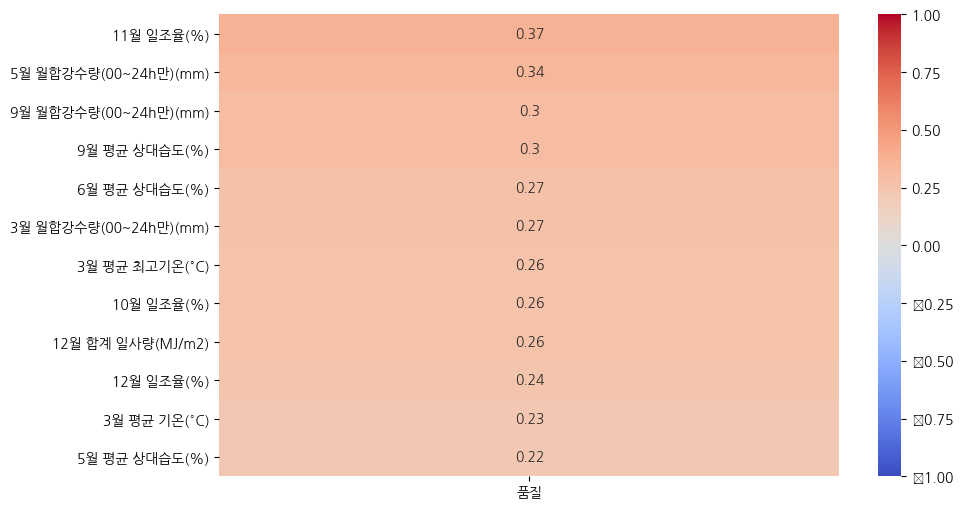

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(quality_correlation[1:13].to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

### 2. 켄달의 상관계수

In [ ]:
# '품질' 칼럼과 다른 연속형 변수들 간의 상관계수 계산
correlation_matrix2 = fuji_df_result.corr(method='kendall')

# '품질' 칼럼과의 상관계수만 추출 및 정렬
quality_correlation2 = correlation_matrix2['품질'].sort_values(ascending=False)

quality_correlation2[1:12]

11월 일조율(%)               0.291980
5월 월합강수량(00~24h만)(mm)    0.268926
9월 평균 상대습도(%)            0.245703
9월 월합강수량(00~24h만)(mm)    0.243541
6월 평균 상대습도(%)            0.214902
3월 평균 최고기온(°C)           0.210013
3월 월합강수량(00~24h만)(mm)    0.207834
12월 합계 일사량(MJ/m2)        0.205395
10월 일조율(%)               0.202580
3월 평균 기온(°C)             0.187740
12월 일조율(%)               0.187011
Name: 품질, dtype: float64

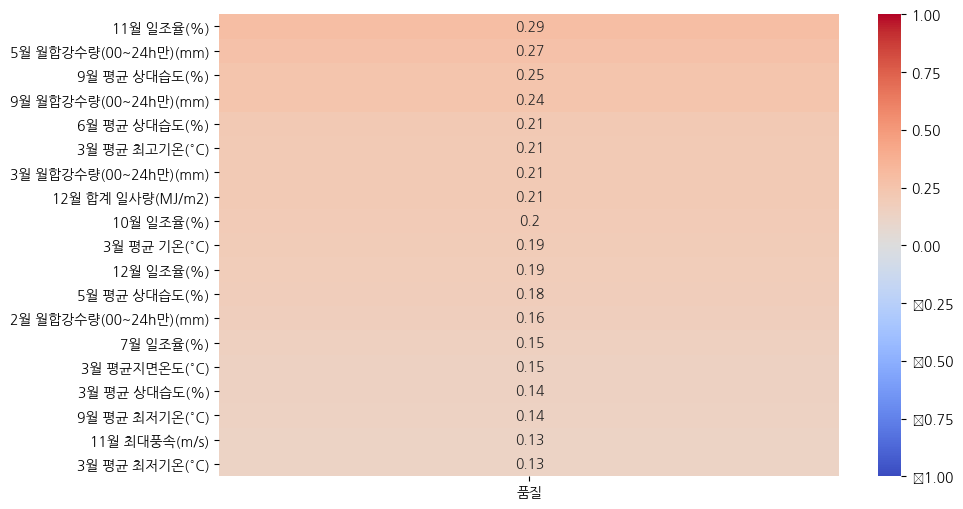

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(quality_correlation2[1:20].to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

=> 두 상관계수의 결과가 거의 동일하다.

---

# **5. 상관분석 후 데이터 프레임**

 스피어만 상관분석으로 뽑은 변수 10개와 조사일, 과원이름, 품질 칼럼만 남아있는 데이터 프레임 생성

In [ ]:
# 스피어만 상관계수를 활용하여 얻어낸 변수 10개만 사용하도록 지정
selected_cols = quality_correlation[1:11].index
selected_cols = ['조사일', '과원이름'] + list(selected_cols) #조사일, 과원이름 칼럼은 삭제x
fuji_df_corr = fuji_df_result[selected_cols]
fuji_df_corr['품질'] = fuji_df_result['품질']

In [ ]:
# 최종 데이터프레임
fuji_df_corr

,조사일,과원이름,11월 일조율(%),5월 월합강수량(00~24h만)(mm),9월 월합강수량(00~24h만)(mm),9월 평균 상대습도(%),6월 평균 상대습도(%),3월 월합강수량(00~24h만)(mm),3월 평균 최고기온(°C),10월 일조율(%),12월 합계 일사량(MJ/m2),12월 일조율(%),품질
0,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2
1,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2
2,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,4
3,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2
4,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.20,3
708,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.20,2
709,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.20,3
710,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.20,2


---

# **6. 새로운 변수 추가**

### (1) 태풍 칼럼 추가

-> 태풍은 수확기에 가까운 태풍에만 영향을 받으므로 작년 수확기 이후의 태풍은 고려하지 않았다.

즉, 당해 연도의 태풍 발생만 고려하였다. 따라서 지금까지 기상데이터는 월별 데이터였지만 태풍 칼럼은 연도별 데이터로 입력된다.

* 연도별 발생 횟수:

    2015: 4회   |   2016: 2회   |  2017: 3회

    2018: 5회   |   2019: 7회   |  2020: 4회

    2021: 3회   |   2022: 5회

* 태풍 평균 강도 = 각 태풍의 최대 풍속 / 당해 연도 발생 횟수

In [ ]:
# 조사일에서 연도 추출
fuji_df_corr['조사연도'] = 0
for i in range(len(fuji_df_corr)):
    fuji_df_corr['조사연도'].iloc[i] = final_df_result['조사일'].iloc[i].year

fuji_df_corr.head()

,조사일,과원이름,11월 일조율(%),5월 월합강수량(00~24h만)(mm),9월 월합강수량(00~24h만)(mm),9월 평균 상대습도(%),6월 평균 상대습도(%),3월 월합강수량(00~24h만)(mm),3월 평균 최고기온(°C),10월 일조율(%),12월 합계 일사량(MJ/m2),12월 일조율(%),품질,조사연도
0,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2,2015
1,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2,2015
2,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,4,2015
3,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2,2015
4,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,1,2015


In [ ]:
# 2015~2022년 태풍횟수와 태풍평균강도 칼럼 생성
fuji_df_corr['태풍횟수'] = fuji_df_corr['조사연도'].map({
        2015: 4,
        2016: 2,
        2017: 3,
        2018: 5,
        2019: 7,
        2020: 4,
        2021: 3,
        2022: 5
})

fuji_df_corr['태풍평균강도'] = fuji_df_corr['조사연도'].map({
        2015: 54.25,
        2016: 49.5,
        2017: 41,
        2018: 40.2,
        2019: 38.57,
        2020: 42,
        2021: 34,
        2022: 33.6
})

### (2) 폭염 일수 칼럼 추가

* 폭염 일수 : 지역 별로 각 수확년도에 체감온도가 33도 이상이었던 날 횟수
 - 위 변수인 태풍 횟수와 마찬가지로 연도별 데이터로 입력된다.

In [ ]:
# 폭염 일수
hot_dict = {
    '충주': [12, 28, 12, 37, 16, 6, 16, 10],
    '김제': [17, 39, 29, 48, 32, 25, 24, 22],
    '완주': [17, 39, 29, 48, 32, 25, 24, 22],
    '남해': [13, 37, 35, 42, 22, 14, 14, 9],
    '포천': [8, 31, 17, 36, 17, 9, 25, 15],
    '화성': [17, 37, 25, 41, 20, 14, 27, 17],
    '군위': [16, 29, 28, 35, 22, 29, 17, 39],
    '춘천': [None, None, 14, 29, 15, 10, 24, 16]
}

for region in hot_dict.keys():
    hot_list = hot_dict[region]
    for year, hot_days in zip(range(2015, 2023), hot_list):
        fuji_df_corr.loc[(final_df_result['과원이름'] == region) & (fuji_df_corr['조사연도'] == year), '폭염일수'] = hot_days

### (3) 장마 칼럼

: 정확한 구분을 위해 장마 일수와 합계 강수량 두 개의 칼럼 추가

In [ ]:
# (1) 장마 일수
rain_days = {
    '충주': [35, 37, 29, 16, 34, 54, 17, 33],
    '김제': [36, 29, 31, 14, 33, 38, 17, 33],
    '완주': [36, 29, 31, 14, 33, 38, 17, 33],
    '남해': [36, 29, 31, 14, 33, 38, 17, 33],
    '포천': [35, 37, 29, 16, 34, 54, 17, 33],
    '화성': [35, 37, 29, 16, 34, 54, 17, 33],
    '군위': [36, 29, 31, 14, 33, 38, 17, 33],
    '춘천': [35, 37,29, 16, 34, 54, 17, 33]
}

for region in rain_days.keys():
    rain_day = rain_days[region]
    for year, days in zip(range(2015, 2023), rain_day):
        fuji_df_corr.loc[(final_df_result['과원이름'] == region) & (fuji_df_corr['조사연도'] == year), '장마일수'] = days

In [ ]:
# (2) 합계강수량
total_precipi_dict = {
    '충주': [228.3, 399.8, 375.3, 209.4, 169.1, 814.3, 304.5, 528],
    '김제': [193.5, 320.3, 188, 289, 233.1, 682, 220.4, 262.6],
    '완주': [193.5, 320.3, 188, 289, 233.1, 682, 220.4, 262.6],
    '남해': [420.2, 309.6, 156.9, 482.8, 784.9, 843.6, 503, 249.1],
    '포천': [475.5, 456.1, 575.1, 268.9, 265, 1085.4, 115.8, 558.7],
    '화성': [242.2, 324.3, 579.7, 320.1, 185, 1057.9, 123.7, 622.9],
    '군위': [195, 189, 91.6, 266, 253.9, 381.6, 147.9, 124.8],
    '춘천': [257.8, 625.9, 530.4, 316.7, 174.5, 944.1, 156.4, 525]
}

for region in total_precipi_dict.keys():
    total_precipi_list = total_precipi_dict[region]
    for year, total_precipi in zip(range(2015, 2023), total_precipi_list):
        fuji_df_corr.loc[(final_df_result['과원이름'] == region) & (fuji_df_corr['조사연도'] == year), '합계강수량'] = total_precipi

In [ ]:
fuji_df_corr

,조사일,과원이름,11월 일조율(%),5월 월합강수량(00~24h만)(mm),9월 월합강수량(00~24h만)(mm),9월 평균 상대습도(%),6월 평균 상대습도(%),3월 월합강수량(00~24h만)(mm),3월 평균 최고기온(°C),10월 일조율(%),12월 합계 일사량(MJ/m2),12월 일조율(%),품질,조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
0,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2,2015,4,54.25,17.0,36.0,193.5
1,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2,2015,4,54.25,17.0,36.0,193.5
2,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,4,2015,4,54.25,17.0,36.0,193.5
3,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2,2015,4,54.25,17.0,36.0,193.5
4,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,1,2015,4,54.25,17.0,36.0,193.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.20,3,2022,5,33.60,9.0,33.0,249.1
708,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.20,2,2022,5,33.60,9.0,33.0,249.1
709,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.20,3,2022,5,33.60,9.0,33.0,249.1
710,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.20,2,2022,5,33.60,9.0,33.0,249.1


---

# **7. EDA**

- 다른 파일 참고

### **1) 데이터 확인**

In [ ]:
fuji_df_corr.head()

,조사일,과원이름,11월 일조율(%),5월 월합강수량(00~24h만)(mm),9월 월합강수량(00~24h만)(mm),9월 평균 상대습도(%),6월 평균 상대습도(%),3월 월합강수량(00~24h만)(mm),3월 평균 최고기온(°C),10월 일조율(%),12월 합계 일사량(MJ/m2),12월 일조율(%),품질,조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
0,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2,2015,4,54.25,17.0,36.0,193.5
1,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2,2015,4,54.25,17.0,36.0,193.5
2,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,4,2015,4,54.25,17.0,36.0,193.5
3,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,2,2015,4,54.25,17.0,36.0,193.5
4,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14,222.33,47.38,1,2015,4,54.25,17.0,36.0,193.5


In [ ]:
fuji_df_corr.tail()

,조사일,과원이름,11월 일조율(%),5월 월합강수량(00~24h만)(mm),9월 월합강수량(00~24h만)(mm),9월 평균 상대습도(%),6월 평균 상대습도(%),3월 월합강수량(00~24h만)(mm),3월 평균 최고기온(°C),10월 일조율(%),12월 합계 일사량(MJ/m2),12월 일조율(%),품질,조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
707,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.2,3,2022,5,33.6,9.0,33.0,249.1
708,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.2,2,2022,5,33.6,9.0,33.0,249.1
709,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.2,3,2022,5,33.6,9.0,33.0,249.1
710,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.2,2,2022,5,33.6,9.0,33.0,249.1
711,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,NaN,248.82,62.2,2,2022,5,33.6,9.0,33.0,249.1


In [ ]:
fuji_df_corr.shape

(712, 19)

In [ ]:
# 데이터 정보 확인
fuji_df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   조사일                    712 non-null    datetime64[ns]
 1   과원이름                   712 non-null    object        
 2   11월 일조율(%)             712 non-null    float64       
 3   5월 월합강수량(00~24h만)(mm)  712 non-null    float64       
 4   9월 월합강수량(00~24h만)(mm)  712 non-null    float64       
 5   9월 평균 상대습도(%)          712 non-null    float64       
 6   6월 평균 상대습도(%)          712 non-null    float64       
 7   3월 월합강수량(00~24h만)(mm)  712 non-null    float64       
 8   3월 평균 최고기온(°C)         712 non-null    float64       
 9   10월 일조율(%)             652 non-null    float64       
 10  12월 합계 일사량(MJ/m2)      419 non-null    float64       
 11  12월 일조율(%)             712 non-null    float64       
 12  품질                     712 non-null    int64         
 13  조사연도 

In [ ]:
# 데이터의 기술 통계량 확인
fuji_df_corr.describe()

,11월 일조율(%),5월 월합강수량(00~24h만)(mm),9월 월합강수량(00~24h만)(mm),9월 평균 상대습도(%),6월 평균 상대습도(%),3월 월합강수량(00~24h만)(mm),3월 평균 최고기온(°C),10월 일조율(%),12월 합계 일사량(MJ/m2),12월 일조율(%),품질,조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,652.000000,419.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,56.574860,103.680899,135.477809,76.005618,70.964888,62.512500,13.930197,58.458160,237.607279,58.212542,2.712079,2018.488764,4.390449,40.021545,23.616573,27.778090,345.379916
std,9.471232,77.750085,94.463642,4.908155,7.648403,58.249397,0.994175,9.257447,26.471594,8.488920,0.709565,1.737285,1.417916,4.111122,11.594553,10.911802,195.148732
min,23.880000,13.400000,25.300000,68.000000,56.000000,9.000000,12.200000,32.720000,185.350000,42.750000,1.000000,2015.000000,2.000000,33.600000,6.000000,16.000000,147.900000
25%,53.250000,30.825000,62.400000,72.000000,67.000000,24.100000,13.300000,52.900000,215.470000,51.320000,2.000000,2017.000000,3.000000,38.570000,14.000000,16.000000,188.000000
50%,58.340000,84.300000,109.000000,75.000000,71.000000,38.700000,13.900000,60.980000,248.120000,58.940000,3.000000,2018.000000,5.000000,40.200000,20.000000,29.000000,268.900000
75%,61.160000,180.000000,190.100000,80.000000,77.000000,86.000000,14.600000,66.140000,253.860000,66.710000,3.000000,2020.000000,5.000000,41.000000,36.000000,34.000000,503.000000
max,72.770000,242.900000,405.000000,89.000000,83.000000,294.000000,15.600000,69.250000,285.630000,74.620000,4.000000,2022.000000,7.000000,54.250000,41.000000,54.000000,1057.900000


*  결측치 확인 및 평균으로 대체

<Axes: >

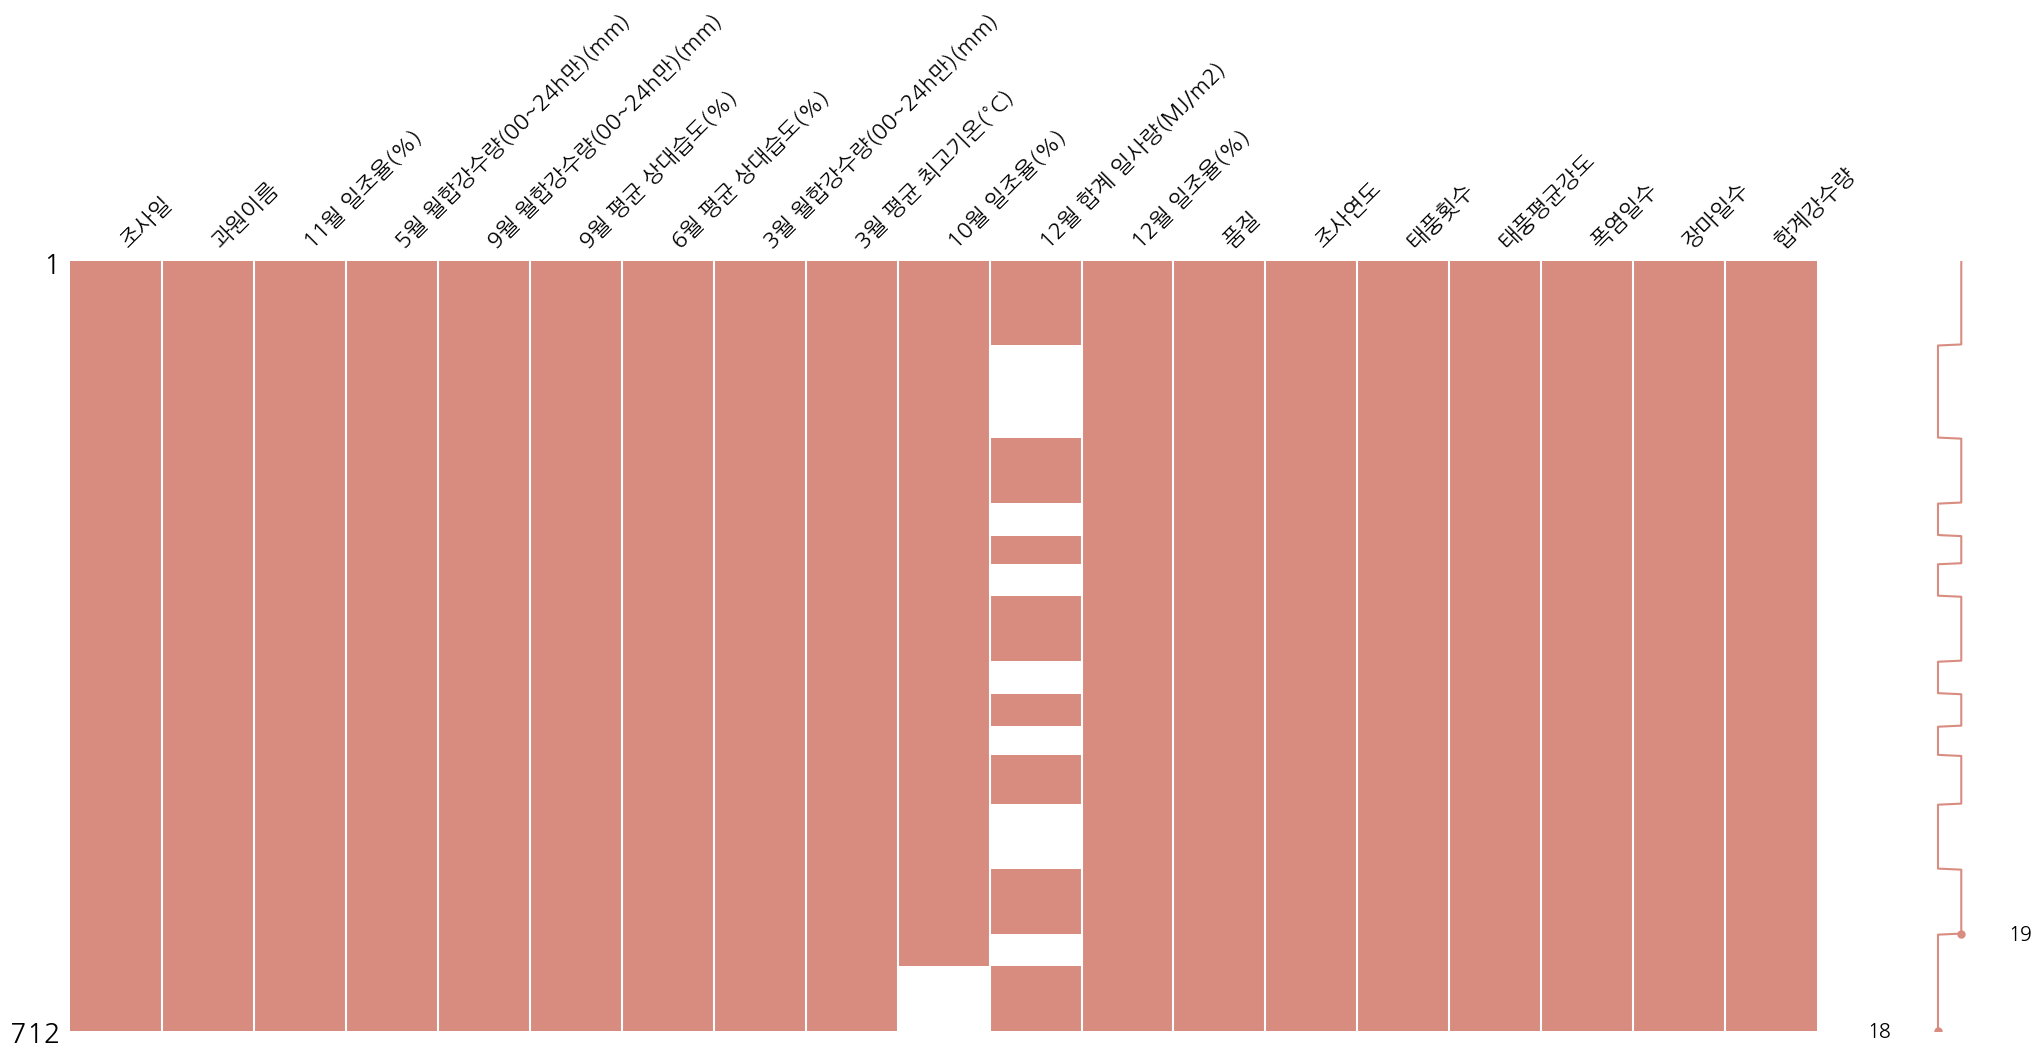

In [ ]:
# 데이터의 결측치 확인
import missingno as mino
mino.matrix(fuji_df_corr, color=(0.85, 0.55, 0.5))

=> 12월 합계 일사량, 10월 일조율에 null값이 존재한다.

In [ ]:
fuji_df_corr.isnull().sum()

조사일                        0
과원이름                       0
11월 일조율(%)                 0
5월 월합강수량(00~24h만)(mm)      0
9월 월합강수량(00~24h만)(mm)      0
9월 평균 상대습도(%)              0
6월 평균 상대습도(%)              0
3월 월합강수량(00~24h만)(mm)      0
3월 평균 최고기온(°C)             0
10월 일조율(%)                60
12월 합계 일사량(MJ/m2)        293
12월 일조율(%)                 0
품질                         0
조사연도                       0
태풍횟수                       0
태풍평균강도                     0
폭염일수                       0
장마일수                       0
합계강수량                      0
dtype: int64

In [ ]:
# 결측치를 평균으로 변경
null_columns = fuji_df_corr.columns[fuji_df_corr.isnull().any()]
for col in null_columns:
    mean_value = fuji_df_corr[col].mean()
    fuji_df_corr[col].fillna(mean_value, inplace=True)

In [ ]:
# 결측치 갯수 확인
fuji_df_corr.isnull().sum()

조사일                      0
과원이름                     0
11월 일조율(%)               0
5월 월합강수량(00~24h만)(mm)    0
9월 월합강수량(00~24h만)(mm)    0
9월 평균 상대습도(%)            0
6월 평균 상대습도(%)            0
3월 월합강수량(00~24h만)(mm)    0
3월 평균 최고기온(°C)           0
10월 일조율(%)               0
12월 합계 일사량(MJ/m2)        0
12월 일조율(%)               0
품질                       0
조사연도                     0
태풍횟수                     0
태풍평균강도                   0
폭염일수                     0
장마일수                     0
합계강수량                    0
dtype: int64

In [ ]:
fuji_df_corr

,조사일,과원이름,11월 일조율(%),5월 월합강수량(00~24h만)(mm),9월 월합강수량(00~24h만)(mm),9월 평균 상대습도(%),6월 평균 상대습도(%),3월 월합강수량(00~24h만)(mm),3월 평균 최고기온(°C),10월 일조율(%),12월 합계 일사량(MJ/m2),12월 일조율(%),품질,조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
0,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14000,222.33,47.38,2,2015,4,54.25,17.0,36.0,193.5
1,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14000,222.33,47.38,2,2015,4,54.25,17.0,36.0,193.5
2,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14000,222.33,47.38,4,2015,4,54.25,17.0,36.0,193.5
3,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14000,222.33,47.38,2,2015,4,54.25,17.0,36.0,193.5
4,2015-11-02,김제,51.68,40.6,36.7,72.0,70.0,30.5,14.3,66.14000,222.33,47.38,1,2015,4,54.25,17.0,36.0,193.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,58.45816,248.82,62.20,3,2022,5,33.60,9.0,33.0,249.1
708,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,58.45816,248.82,62.20,2,2022,5,33.60,9.0,33.0,249.1
709,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,58.45816,248.82,62.20,3,2022,5,33.60,9.0,33.0,249.1
710,2022-10-27,포천,54.76,16.4,204.5,79.0,81.0,91.0,13.6,58.45816,248.82,62.20,2,2022,5,33.60,9.0,33.0,249.1


In [ ]:
#해당 데이터는 제공됐으므로 주석처리
#fuji_df_corr.to_excel('fuji_eda_data.xlsx', index=False)

---

# **8. 데이터 전처리**

* target data 라벨인코딩

In [ ]:
encoder = LabelEncoder()
encoder.fit(fuji_df_corr['품질'])
fuji_df_corr['품질'] = encoder.transform(fuji_df_corr['품질'])

* X, Y 분리

In [ ]:
y = fuji_df_corr[['품질']]
X = fuji_df_corr.drop(columns=['품질', '조사일', '조사연도','과원이름'])

* train, test 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

* 수치형 데이터 스케일링

In [ ]:
# X 변수들 스케일링
standard_scaler = StandardScaler()

columns = ['11월 일조율(%)', '5월 월합강수량(00~24h만)(mm)', '9월 월합강수량(00~24h만)(mm)',
            '9월 평균 상대습도(%)', '6월 평균 상대습도(%)', '3월 월합강수량(00~24h만)(mm)',
            '3월 평균 최고기온(°C)', '10월 일조율(%)', '12월 합계 일사량(MJ/m2)', '12월 일조율(%)',
            '태풍횟수', '태풍평균강도', '폭염일수', '장마일수', '합계강수량']

train_numeric = X_train[columns]
test_numeric = X_test[columns]

stan_fit = standard_scaler.fit(train_numeric)
train_numeric_scaled = stan_fit.transform(train_numeric)
test_numeric_scaled = stan_fit.transform(test_numeric)

X_train[columns] = train_numeric_scaled
X_test[columns] = test_numeric_scaled

---

# **9. 모델 학습 및 예측**

In [ ]:
# 모델을 평가하는 함수 정의
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

## **1. xgbclassifier**

* grid search

In [ ]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# XGBoost 분류 모델 생성
xgb = XGBClassifier(objective="multi:softprob", num_class=4, random_state=42)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True), cv=3)
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 300}


* model fitting

In [ ]:
# 최적의 파라미터로 모델 생성
best_xgb = grid_search.best_estimator_

# 모델 학습
best_xgb.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = best_xgb.predict(X_test)

* 모델 성능 평가

In [ ]:
get_clf_eval(y_test, y_pred)

오차 행렬
[[ 0  7  2  0]
 [ 0 24 27  0]
 [ 0  8 92  1]
 [ 0  3 13  1]]
정확도: 0.6573, 정밀도: 0.6010, 재현율: 0.6573, F1:0.6022


* feature importance

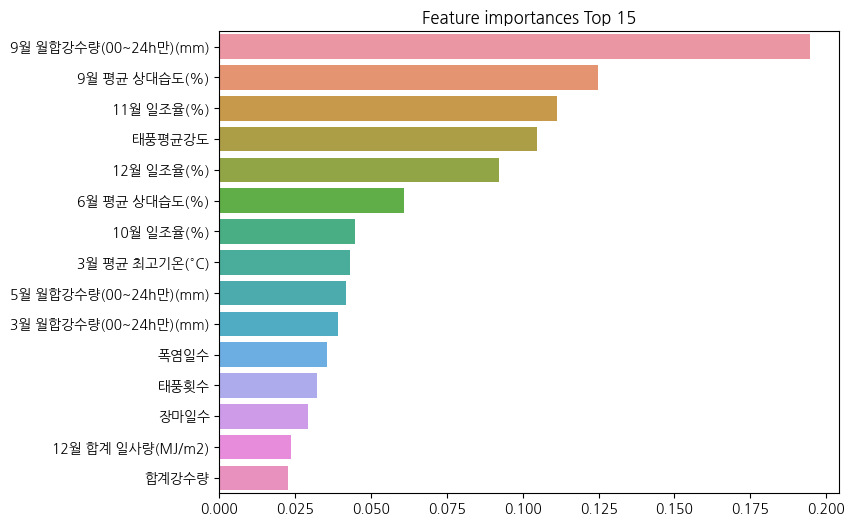

In [ ]:
ftr_importances_values = best_xgb.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [ ]:
ftr_importances.sort_values(ascending=False)[:15]

9월 월합강수량(00~24h만)(mm)    0.194696
9월 평균 상대습도(%)            0.124653
11월 일조율(%)               0.111277
태풍평균강도                   0.104741
12월 일조율(%)               0.092165
6월 평균 상대습도(%)            0.060961
10월 일조율(%)               0.044797
3월 평균 최고기온(°C)           0.043034
5월 월합강수량(00~24h만)(mm)    0.041768
3월 월합강수량(00~24h만)(mm)    0.039062
폭염일수                     0.035383
태풍횟수                     0.032020
장마일수                     0.029284
12월 합계 일사량(MJ/m2)        0.023460
합계강수량                    0.022697
dtype: float32

## **2) randomforest**

* grid search

In [ ]:
params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [2, 4, 8],
    'min_samples_split': [2, 5, 10, 20],
    'random_state': [42]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행 (n_jobs=-1: 모든 CPU 코어를 이용해 학습)
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
grid_search2 = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1)
grid_search2.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n',grid_search2.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_search2.best_score_))

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

최적 하이퍼 파라미터:
 {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
최고 예측 정확도: 0.6910


* model fitting

In [ ]:
# 최적의 파라미터로 모델 생성
best_rf = grid_search2.best_estimator_

# 모델 학습
best_rf.fit(X_train, y_train)

# 검증 데이터 예측
y_pred2 = best_rf.predict(X_test)

* 모델 성능 평가

In [ ]:
get_clf_eval(y_test, y_pred2)

오차 행렬
[[ 0  7  2  0]
 [ 0 24 27  0]
 [ 0  8 92  1]
 [ 0  3 13  1]]
정확도: 0.6573, 정밀도: 0.6010, 재현율: 0.6573, F1:0.6022


* feature importance

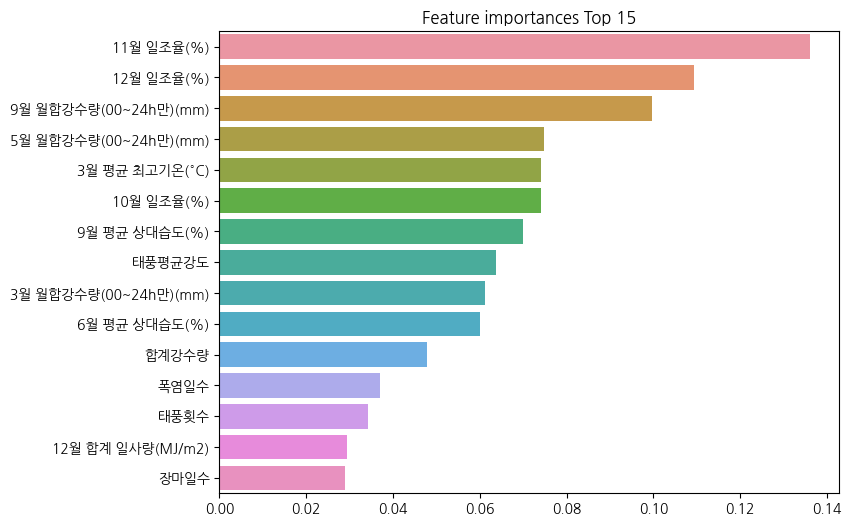

In [ ]:
ftr_importances_values = best_rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [ ]:
ftr_importances.sort_values(ascending=False)[:10]

11월 일조율(%)               0.136052
12월 일조율(%)               0.109332
9월 월합강수량(00~24h만)(mm)    0.099719
5월 월합강수량(00~24h만)(mm)    0.074825
3월 평균 최고기온(°C)           0.074061
10월 일조율(%)               0.074039
9월 평균 상대습도(%)            0.069896
태풍평균강도                   0.063716
3월 월합강수량(00~24h만)(mm)    0.061085
6월 평균 상대습도(%)            0.060008
dtype: float64

## **3) SVM**

* grid search

In [ ]:
# SVM 모델을 생성합니다.
svm = SVC()

# 튜닝할 하이퍼파라미터 그리드를 정의합니다.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'decision_function_shape': ['ovr', 'ovo'],
}

# 그리드 서치
grid_search3 = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search3.fit(X_train, y_train)

# 최적의 하이퍼파라미터를 얻습니다.
best_params = grid_search3.best_params_
print('최적 하이퍼 파라미터:\n',grid_search3.best_params_)

최적 하이퍼 파라미터:
 {'C': 10, 'decision_function_shape': 'ovr', 'kernel': 'poly'}


* model fitting

In [ ]:
# 최적의 파라미터로 모델 생성
best_svm = grid_search3.best_estimator_

# 모델 학습
best_svm.fit(X_train, y_train)

# 검증 데이터 예측
y_pred3 = best_svm.predict(X_test)

* 모델 성능 평가

In [ ]:
get_clf_eval(y_test, y_pred3)

오차 행렬
[[ 0  7  2  0]
 [ 0 29 22  0]
 [ 0 11 89  1]
 [ 0  3 13  1]]
정확도: 0.6685, 정밀도: 0.6147, 재현율: 0.6685, F1:0.6195


## **4) gradientboosting**

* grid search

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
}

# GradientBoostingClassifier 모델 객체 생성
gb_model = GradientBoostingClassifier(random_state=42)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search4 = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_search4.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 하이퍼파라미터:", grid_search4.best_params_)
print("최고 정확도:", grid_search4.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
최고 정확도: 0.6853932584269663


* model fitting

In [ ]:
# 최적의 파라미터로 모델 생성
best_gb = grid_search4.best_estimator_

# 모델 학습
best_gb.fit(X_train, y_train)

# 검증 데이터 예측
y_pred4 = best_gb.predict(X_test)

* 모델 성능 평가

In [ ]:
get_clf_eval(y_test, y_pred4)

오차 행렬
[[ 0  7  2  0]
 [ 0 23 28  0]
 [ 0  5 95  1]
 [ 0  3 13  1]]
정확도: 0.6685, 정밀도: 0.6118, 재현율: 0.6685, F1:0.6092


* feature importance

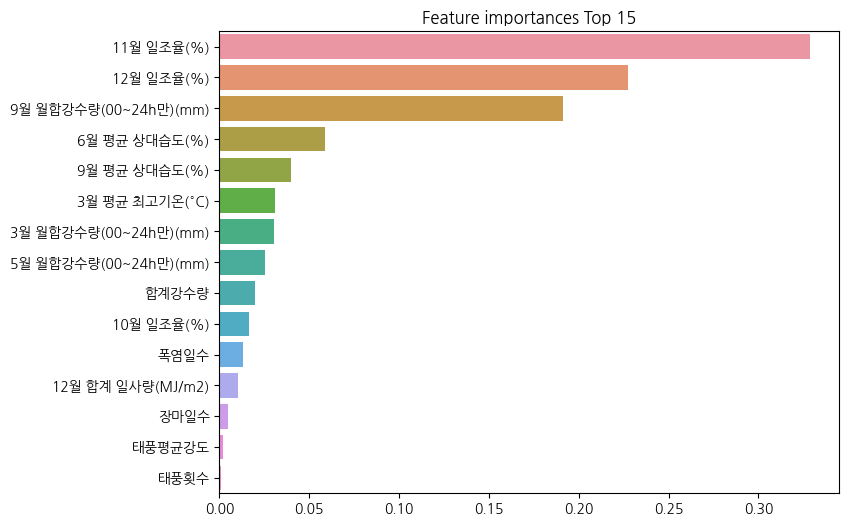

In [ ]:
ftr_importances_values = best_gb.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [ ]:
ftr_importances.sort_values(ascending=False)[:10]

11월 일조율(%)               0.328691
12월 일조율(%)               0.227302
9월 월합강수량(00~24h만)(mm)    0.191407
6월 평균 상대습도(%)            0.058686
9월 평균 상대습도(%)            0.039750
3월 평균 최고기온(°C)           0.031053
3월 월합강수량(00~24h만)(mm)    0.030078
5월 월합강수량(00~24h만)(mm)    0.025322
합계강수량                    0.019945
10월 일조율(%)               0.016530
dtype: float64

## **5) adaboost**

* grid search

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'base_estimator__max_depth': [1, 2, 3, 4]
}

# AdaBoostClassifier 모델 객체 생성
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), random_state=42)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search5 = GridSearchCV(estimator=ada_model, param_grid=param_grid,
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_search5.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 하이퍼파라미터:", grid_search5.best_params_)
print("최고 정확도:", grid_search5.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarnin

최적의 하이퍼파라미터: {'base_estimator__max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 50}
최고 정확도: 0.6760299625468166


* model fitting

In [ ]:
# 최적의 파라미터로 모델 생성
best_ada = grid_search5.best_estimator_

# 모델 학습
best_ada.fit(X_train, y_train)

# 검증 데이터 예측
y_pred5 = best_ada.predict(X_test)

* 모델 성능 평가

In [ ]:
get_clf_eval(y_test, y_pred5)

오차 행렬
[[ 0  7  2  0]
 [ 0 24 27  0]
 [ 0  8 92  1]
 [ 0  3 13  1]]
정확도: 0.6573, 정밀도: 0.6010, 재현율: 0.6573, F1:0.6022


* feature importance

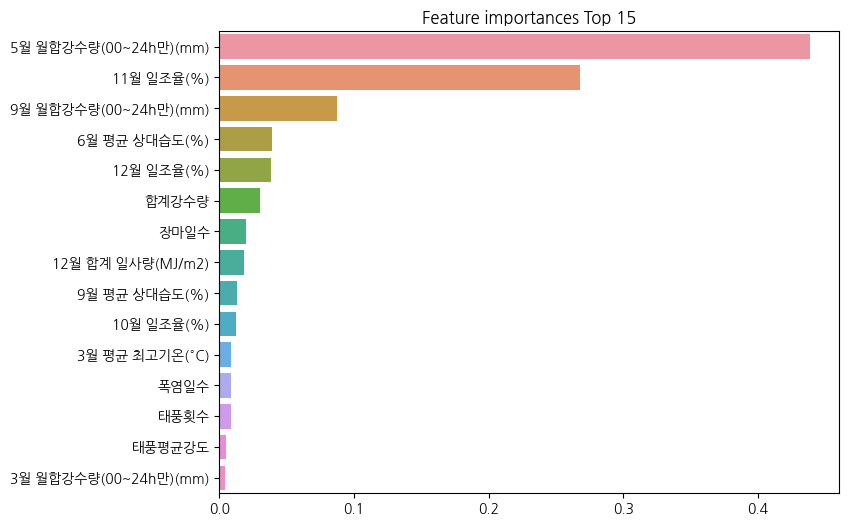

In [ ]:
ftr_importances_values = best_ada.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [ ]:
ftr_importances.sort_values(ascending=False)[:10]

5월 월합강수량(00~24h만)(mm)    0.438730
11월 일조율(%)               0.268245
9월 월합강수량(00~24h만)(mm)    0.087325
6월 평균 상대습도(%)            0.039273
12월 일조율(%)               0.038134
합계강수량                    0.030074
장마일수                     0.020055
12월 합계 일사량(MJ/m2)        0.018365
9월 평균 상대습도(%)            0.013196
10월 일조율(%)               0.012175
dtype: float64

## **6) 앙상블**


In [ ]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier

# Voting Classifier를 사용하여 앙상블 생성
voting_classifier = VotingClassifier(estimators=[
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('ada', best_ada)],
    voting='hard'
    )

# Voting Classifier 학습
voting_classifier.fit(X_train, y_train)

# 각 모델의 예측을 얻을 수 있습니다.
xgb_predictions = best_xgb.predict(X_test)
rf_predictions = best_rf.predict(X_test)
ada_predictions = best_ada.predict(X_test)
voting_predictions = voting_classifier.predict(X_test)

# 성능 평가
get_clf_eval(y_test, voting_predictions)

오차 행렬
[[ 0  7  2  0]
 [ 0 24 27  0]
 [ 0  8 92  1]
 [ 0  3 13  1]]
정확도: 0.6573, 정밀도: 0.6010, 재현율: 0.6573, F1:0.6022


In [ ]:
# 스태킹 앙상블
from sklearn.ensemble import StackingClassifier

# 스태킹 앙상블 생성
stacking_models = [
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('ada', best_ada)
]

stacking_classifier = StackingClassifier(
    estimators=stacking_models
    )

# 스태킹 앙상블 모델 훈련
stacking_classifier.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
stacking_predictions = stacking_classifier.predict(X_test)

# 성능 평가
get_clf_eval(y_test, stacking_predictions)

오차 행렬
[[ 0  7  2  0]
 [ 0 24 27  0]
 [ 0  8 92  1]
 [ 0  3 13  1]]
정확도: 0.6573, 정밀도: 0.6010, 재현율: 0.6573, F1:0.6022


[최종 코드 이외 시도한 내용]

성능 향상을 위하여 반복된 파라미터 튜닝/ 변수 삭제/ 로그 변환 스케일링/ 상관관계 높은 변수들 존재시 둘 중 하나 제거/ 이상치 존재하는 변수 제거/ 피처 중요도로 진행한 모델링 등 방법을 사용하였고 최종 결과물만 코드에 첨부하였다.

---

# **10. 상관분석에서 선택한 최종 모델**

- SVM

In [ ]:
# 최적의 파라미터로 모델 생성
best_svm = grid_search3.best_estimator_

# 모델 학습
best_svm.fit(X_train, y_train)

# 검증 데이터 예측
y_pred3 = best_svm.predict(X_test)

get_clf_eval(y_test, y_pred3)

오차 행렬
[[ 0  7  2  0]
 [ 0 29 22  0]
 [ 0 11 89  1]
 [ 0  3 13  1]]
정확도: 0.6685, 정밀도: 0.6147, 재현율: 0.6685, F1:0.6195
